# The El-Niño Southern Oscillation

An example of a spatio-temporal climate oscillation pattern that can be summarized in a single time series.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import xarray as xr
import cartopy.crs as ccrs
from scipy.signal import detrend
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# some settings for plotting and printing
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.size'] = 18
np.set_printoptions(precision=4, suppress=True)

In [2]:
# uncomment if you haven't done that step yet 
#!wget https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/sst/data.nc -O data/sst_orig.nc
#!ncatted -O -a calendar,T,o,c,"360_day" data/sst_orig.nc data/sst.nc

In [3]:
# load SST file into data sets 
ds_sst = xr.open_dataset("data/sst.nc").squeeze("zlev").drop("zlev")

# we give the dimensions a standard name, e.g., "T" -> "time", etc.
new_dims = {'T': 'time', 'Y': 'latitude', 'X': 'longitude'}
ds_sst = ds_sst.rename(new_dims).set_coords(['longitude', 'latitude', 'time'])

# select a time period using ".sel()"
# and "slice" the time for the period between 1950 and 2022
ds_sst = ds_sst.sel(time=slice("1949-09","2022"))

In [4]:
# define a function that subtracts the mean along the "time" dimension
def subtract(x):
    return x - x.mean(dim="time")

# define our custom detrend function that also fills NaNs with 0s
def detrend_(x):
    return detrend(x.fillna(0),axis=0)

In [5]:
# we'll keep a copy after each step as reference ("ds0","ds1","ds2")
# but override "ds_sst"
ds0 = ds_sst*1.0

# apply the detrending
ds_sst = ds_sst.map(detrend_)
ds1 = ds_sst*1.0

# apply the subtraction of the monthly means, using "groupby"
ds_sst = ds_sst.groupby("time.month").map(subtract)
ds2 = ds_sst*1.0

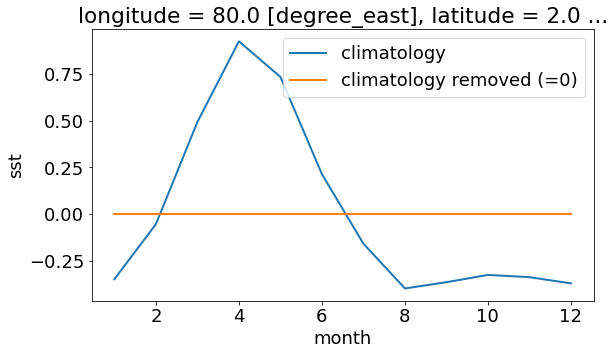

In [6]:
# plot the climatological monthly means as time series for a location (80E, 2N)
ds1["sst"].groupby("time.month").mean() \
    .sel(longitude=80,latitude=2).plot(label="climatology",lw=2)
ds2["sst"].groupby("time.month").mean() \
    .sel(longitude=80,latitude=2).plot(label="climatology removed (=0)",lw=2)
plt.legend();

In [7]:
# define Nino3.4 region boundaries
lon1 = 360-170; lon2 = 360-120
lat1 = -5; lat2 = 5
# also the other NINO regions
# Nino1.2
lon1_12 = 360-90; lon2_12 = 360-80
lat1_12 = -10; lat2_12 = 0
# Nino3
lon1_3 = 360-150; lon2_3 = 360-90
lat1_3 = -5; lat2_3 = 5
# Nino4
lon1_4 = 160; lon2_4 = 360-150
lat1_4 = -5; lat2_4 = 5

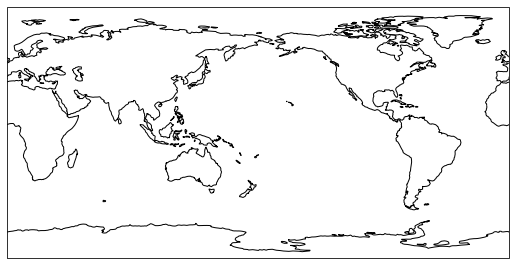

In [8]:
# define projection of SST data: lonlat grid -> "PlateCarree()"
data_proj = ccrs.PlateCarree()
# define projection for maps
proj = ccrs.PlateCarree(central_longitude=180)

# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();

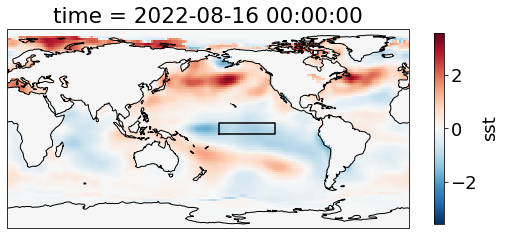

In [9]:
# plot SST anomalies for last month,
# i.e, the last time index, -1
ds_sst["sst"][-1].plot(ax=ax,transform=data_proj,cbar_kwargs={"shrink": 0.7})
# plot extend of Nino3.4
nino34 = [lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1]
ax.plot(*nino34,'k-',transform=data_proj)
fig

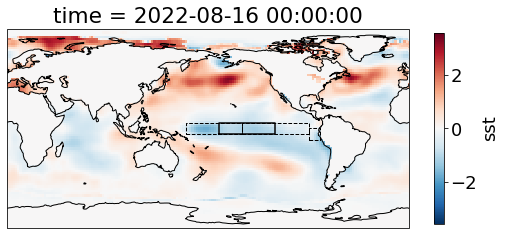

In [10]:
# add other Nino region outlines 
nino12 = [lon1_12,lon2_12,lon2_12,lon1_12,lon1_12],[lat1_12,lat1_12,lat2_12,lat2_12,lat1_12]
ax.plot(*nino12,'k--',lw=1,transform=data_proj)
nino3 = [lon1_3,lon2_3,lon2_3,lon1_3,lon1_3],[lat1_3,lat1_3,lat2_3,lat2_3,lat1_3]
ax.plot(*nino3,'k--',lw=1,transform=data_proj)
nino4 = [lon1_4,lon2_4,lon2_4,lon1_4,lon1_4],[lat1_4,lat1_4,lat2_4,lat2_4,lat1_4]
ax.plot(*nino4,'k--',lw=1,transform=data_proj);
fig

In [11]:
# slice dataset along Nino3.4 boundaries
# i.e., between "lon1" and "lon2",
# and between "lat1" and "lat2"
sst = ds_sst["sst"].loc[{
    'latitude': slice(lat1,lat2),
    'longitude': slice(lon1,lon2)
}]

# fill all masked values (land) with 0s
x = sst.fillna(0).values
# print dimensions of Nino3.4 SST data
print("Original dimensions:", x.shape)

# save the dimensions
nt, ny, nx = x.shape

# reshape array into matrix with time and space dimension, only
# i.e, nt,nx*ny
x = np.reshape(x,(nt,ny*nx))
print("New dimensions:     ",x.shape)
# store number of principipal components (for later)
n_components = nx*ny

Original dimensions: (876, 5, 26)
New dimensions:      (876, 130)


In [12]:
# THIS LINE HERE IS WHERE THE WHOLE ACTION IS!
u, s, vh = np.linalg.svd(x, full_matrices=True)

# print dimensions of returned matrices
print(u.shape, s.shape, vh.shape)

(876, 876) (130,) (130, 130)


In [13]:
# Let's retrieve the temporal component, i.e., the PCs
coords = [
    ("time", sst["time"].data),
    ("PC",range(1,n_components+1))
]
pc = xr.DataArray(np.dot(u[:,:n_components], np.diag(s))/np.sqrt(n_components), coords=coords).to_pandas()
# a 3-month running mean using "rolling(3)"
pc_3m = pc.rolling(3).mean()
# get the time stamps for the x-axis dates
time = pc.index.to_datetimeindex()
time_3m = pc_3m.index.to_datetimeindex()

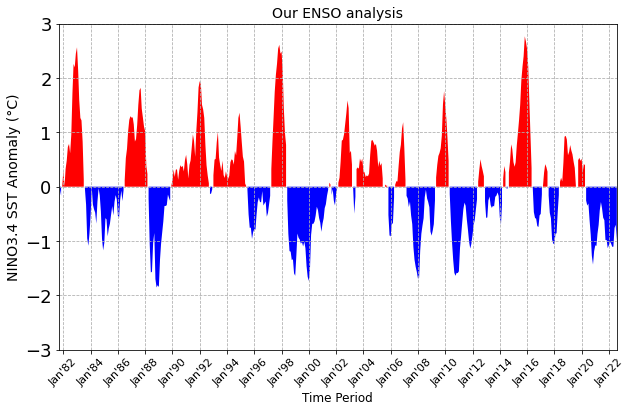

In [14]:
# and plot it all
fig, ax = plt.subplots(figsize=(10,6))
ax.fill_between(time,pc[1],0,where=(pc[1] >= 0), lw=0, color='red')
ax.fill_between(time,pc[1],0,where=(pc[1] < 0), lw=0, color='blue')
ax.set_xlim(time[384],time[-1])
ax.set_title("Our ENSO analysis", fontsize=14)
ax.xaxis.set_major_locator(mdates.YearLocator(2,month=1,day=16))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b'%y"))
ax.tick_params(axis='x', labelrotation=45, labelsize=11)
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-3,3.1,1)))
ax.set_ylim(-3,3)
ax.set_xlabel("Time Period", fontsize=12)
ax.set_ylabel("NINO3.4 SST Anomaly (°C)", fontsize=14)
ax.grid(ls='--')
fig.savefig("figures/our_enso.png",dpi=300,bbox="tight")

<table>
    <tr>
        <td><img src="https://iri.columbia.edu/wp-content/uploads/2022/08/figure2.png" width="450px"/></td>
        <td><img src="figures/our_enso.png" width="500px"/></td>
    </tr>
 </table>

In [15]:
# fill all masked values (land) with 0s
x = sst.fillna(0).values
# print dimensions of Nino3.4 SST data
print(x.shape)

# save the size of each dimension
nt, ny, nx = x.shape

# reshape array into matrix with time and space dimension, only
# i.e, nt,nx*ny
x = np.reshape(x,(nt,ny*nx))
print(x.shape)

(876, 5, 26)
(876, 130)


(876, 130)


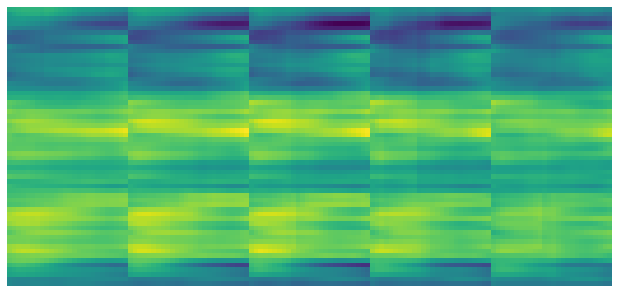

In [16]:
print(x.shape)
# plot matrix for last 5 years (=60 months)
plt.matshow(x[:60,:])
plt.gca().set_axis_off()

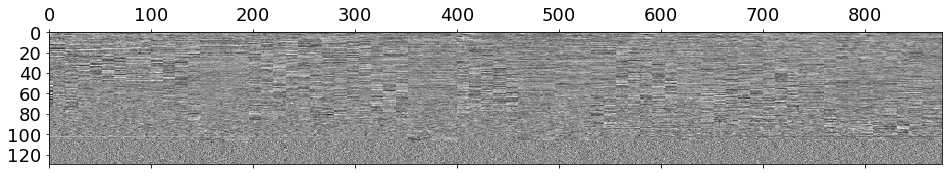

In [17]:
# inspect (transposed) matrix u
plt.matshow(u[:,:n_components].T,cmap="gray");

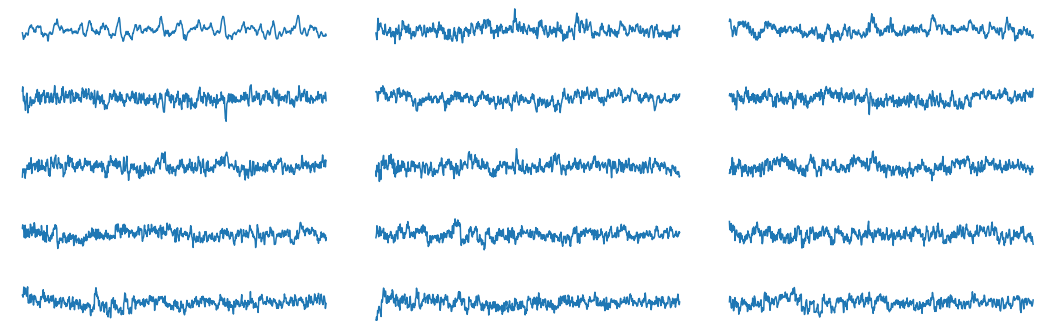

In [18]:
# inspect first 15 elements of "u"
fig, axes = plt.subplots(5,3,sharex=True,sharey=True,figsize=(15,5))
for i,ax in enumerate(axes.flat):
    ax.plot(u[:,i])
    ax.set_axis_off()
fig.tight_layout()

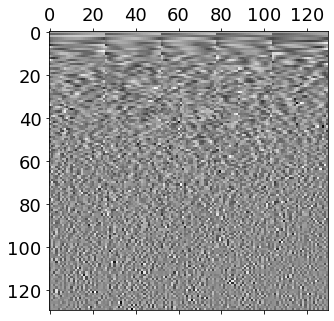

In [19]:
# inspect (already transposed) matrix v
plt.matshow(vh,cmap="gray");

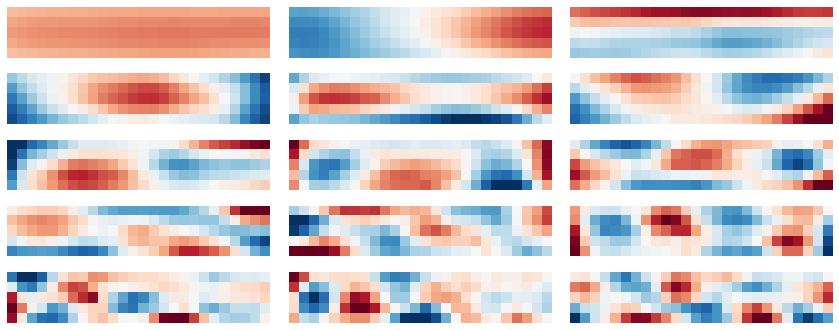

In [20]:
# inspect first 15 elements of "vh"
fig, axes = plt.subplots(5,3,sharex=True,sharey=True,figsize=(12,5))
for i,ax in enumerate(axes.flat):
    # reshape into orginal (ny,nx) shape, i.e., the NINO3.4 region
    im = ax.matshow(np.reshape(vh[i,:],(ny,nx)),cmap="RdBu_r",vmin=-0.2,vmax=0.2)
    ax.set_axis_off()
fig.tight_layout()

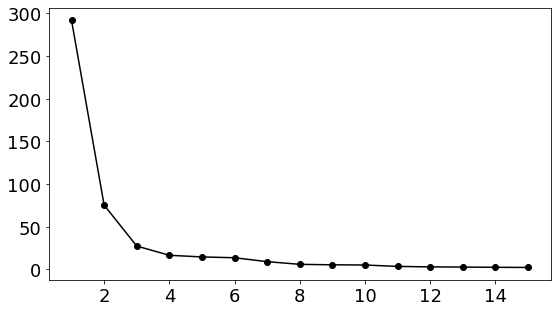

In [21]:
# inspect first 15 (diagonal) elements of matrix "s"
plt.plot(range(1,16),s[:15],'ko-');

Total variance of SST data: 0.811694


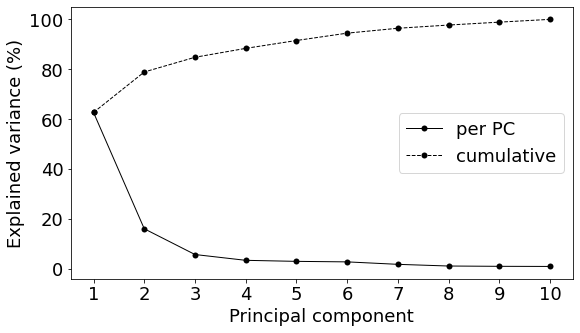

In [22]:
X = s[:10]/np.sum(s[:10])*100
plt.plot(range(1,len(X)+1),X,'ko-',lw=1,mew=0,label='per PC')
plt.xlabel("Principal component")
plt.ylabel("Explained variance (%)")
plt.xticks(range(1,len(X)+1))

plt.plot(range(1,len(X)+1),np.cumsum(X),'ko--',lw=1,mew=0,label='cumulative')
plt.legend();
print("Total variance of SST data: %f"%x.var())

In [23]:
# we refer to the spatial component of the decomposition as EOF
eofs = np.reshape(vh,(n_components,ny,nx))
coords = [ 
    ("n",range(1,n_components+1)),
    ("latitude", sst["latitude"].data),
    ("longitude", sst["longitude"].data)
]
# turn the eofs into an xarray DataArray
eof = xr.DataArray(eofs, coords=coords)

In [24]:
# this is the temporal component, i.e., the PCs
coords = {"time": pd.to_datetime([t.strftime() for t in sst["time"].data]),
          "n": range(1,n_components+1)}
coords = {"time": sst["time"].data,
          "n": range(1,n_components+1)}
ds_pc = xr.Dataset({"PC": (("n","time"), (u[:,:n_components]@np.diag(s)/np.sqrt(n_components)).T)}, coords=coords)
ds_pc.sel(n=1).drop("n").to_netcdf("data/our_enso.nc") # save to NetCDF file for later
pc = ds_pc.to_dataframe()

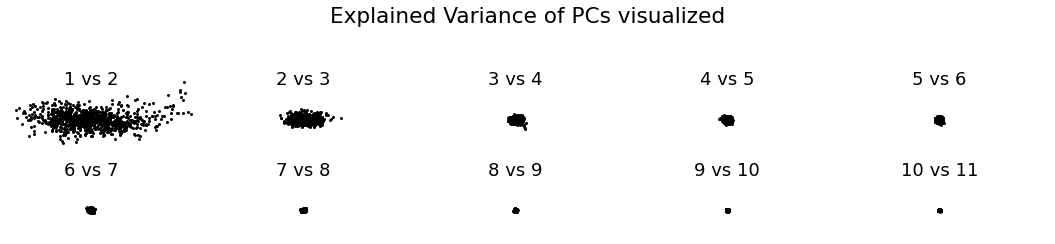

In [25]:
fig, axes = plt.subplots(2,5,sharex=True,sharey=True,figsize=(15,3))
for i,ax in enumerate(axes.flat):
    x = i+1
    y = i+2
    xt,yt = 0,1.1
    ax.plot(pc.loc[x],pc.loc[y],'k.',mew=0)
    ax.text(xt,yt,"%d vs %d"%(x,y),ha='center',va='center')
    ax.set_aspect('equal')
    ax.set_axis_off()
fig.tight_layout()
fig.suptitle("Explained Variance of PCs visualized",y=1.2);

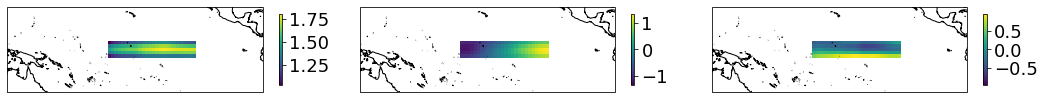

In [26]:
fig, axes = plt.subplots(1,3,subplot_kw={'projection':proj},
                         sharex=True,sharey=True,figsize=(15,3))
for i,ax in enumerate(axes.flat):
    ax.coastlines()
    # eofs are dimensionless unit vectors;
    # multiply them by the square root of the eigenvalues
    # (eigenvalues have units of variance) to get our units back, i.e., °C.
    (s[i]**0.5*eof[i]).plot(ax=ax,transform=data_proj,
                            cmap='viridis',cbar_kwargs={"shrink": 0.4})
    ax.set_extent([130,280,-25,25],crs=data_proj)
    ax.set_title(None)
fig.tight_layout()

In [27]:
sst_all = ds_sst["sst"].fillna(0).values
nt, ny, nx = sst_all.shape
print(sst_all.shape)
sst_all = np.reshape(sst_all,(nt,ny*nx))
print(sst_all.shape)
print(u.shape)

# this is the "matrix" way of doing a regression
X = (u[:,:n_components]/u[:,:n_components].std(axis=0)).T@(sst_all/sst_all.std(axis=0))/nt
sst_eof_corr = np.reshape(X,(n_components,ny,nx))
print(sst_eof_corr.shape)

coords = [("PC",range(1,n_components+1)),
          ("latitude", ds_sst["latitude"].data),
          ("longitude", ds_sst["longitude"].data)]
eof_maps = xr.DataArray(sst_eof_corr, coords=coords)

(876, 89, 180)
(876, 16020)
(876, 876)
(130, 89, 180)


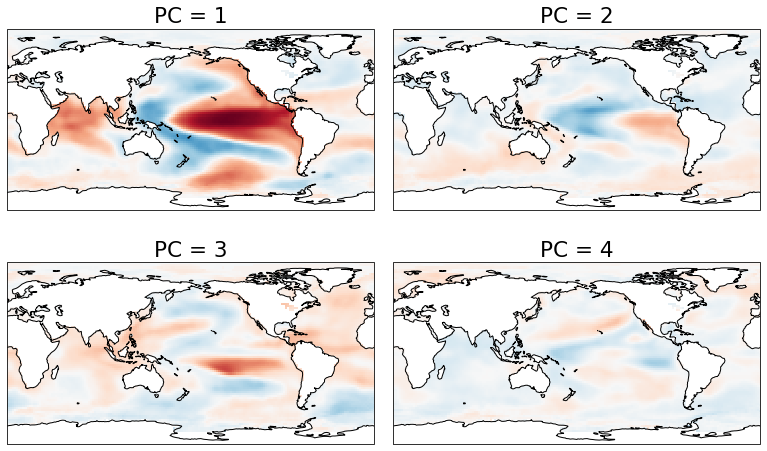

In [28]:
fig, axes = plt.subplots(2,2,subplot_kw={'projection':proj},figsize=(11,7))
for i,ax in enumerate(axes.flat):
    ax.coastlines()
    eof_maps[i].plot(ax=ax,transform=data_proj,
                     cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False)
fig.tight_layout()